In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage
import copy

np.random.seed(2020)


In [2]:
# Read in Data
with open('data/sem_items_new.txt','r') as fid:
    names_items = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_relations_new.txt','r') as fid:
    names_relations = np.array([l.strip() for l in fid.readlines()])
with open('data/sem_attributes_new.txt','r') as fid:
    names_attributes = np.array([l.strip() for l in fid.readlines()])

In [3]:
nobj = len(names_items)
nrel = len(names_relations)
nattributes = len(names_attributes)
print('List of items:')
print(*names_items,sep=',')
print("\nList of relations:")
print(*names_relations,sep=',')
print("\nList of attributes:")
print(*names_attributes,sep=',')

List of items:
Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile

List of relations:
ISA,Is,Can,Has

List of attributes:
Living thing,Plant,Animal,Tree,Flower,Bird,Fish,Reptile,Pine,Oak,Rose,Daisy,Robin,Canary,Sunfish,Salmon,Turtle,Crocodile,Pretty,Big,Living,Green,Red,Yellow,Slow,Grow,Move,Swim,Fly,Sing,Skin,Roots,Leaves,Bark,Branch,Petals,Wings,Feathers,Gills,Scales,Backbone,Produce Eggs,Shell


In [4]:
item_display_ind = 35 # can change, just represents index of input data to show as example.

D = np.loadtxt('data/sem_data_new.txt')
input_pats = D[:,:nobj+nrel]
input_pats = torch.tensor(input_pats,dtype=torch.float)
output_pats = D[:,nobj+nrel:]
output_pats = torch.tensor(output_pats,dtype=torch.float)
N = input_pats.shape[0] # number of training patterns



input_v = input_pats[item_display_ind,:].numpy().astype('bool')
output_v = output_pats[item_display_ind,:].numpy().astype('bool')
print('Example input pattern:')
print(input_v.astype('int'))
print('Example output pattern:')
print(output_v.astype('int'))
print("")
print("Which encodes...")
print('Item ',end='')
print(names_items[input_v[:nobj]])
print('Relation ',end='')
print(names_relations[input_v[nobj:]])
print('Attributes ',end='')
print(names_attributes[output_v])

Example input pattern:
[0 0 0 0 0 0 0 0 1 0 0 0 0 1]
Example output pattern:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 1]

Which encodes...
Item ['Turtle']
Relation ['Has']
Attributes ['Skin' 'Backbone' 'Shell']


In [5]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE
        self.i2rep = nn.Linear(nobj,rep_size)
        self.all2h = nn.Linear(rep_size+nrel,hidden_size)
        self.h2o = nn.Linear(hidden_size,nattributes)
        self.sigmoid = torch.sigmoid

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,nobj+nrel) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:nobj] # input to Item Layer [B x nobj Tensor]
        x_rel = x[:,nobj:] # input to Relation Layer [B x nrel Tensor]
        
        rep = self.i2rep(x_item)
        rep = relu(rep)
        to_hidden = torch.cat((rep,x_rel),1)
        hidden = self.all2h(to_hidden)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = self.sigmoid(output)
        
        return output, hidden, rep

In [6]:
loaded_model = torch.load('trained_model.pt')

mynet = Net(rep_size=loaded_model['model_state_dict']['i2rep.weight'].size()[0],
            hidden_size=loaded_model['model_state_dict']['all2h.weight'].size()[0])

mynet.load_state_dict(loaded_model['model_state_dict'])


<All keys matched successfully>

## Model Has been Loaded successfully, now evaluate model

In [7]:
# This will iterate through each possible input pattern, predict outputs, and determine
# if the output matches the expected output. If not, it prints the input pattern index

# ***Should return nothing when ran.

for i in range(input_pats.shape[0]) :
    output = mynet(input_pats[i])[0][0].detach().numpy()
    if np.dot(output_pats[i].numpy(),np.where(output>=.5,1,0)) != np.sum(output_pats[i].numpy()) :
        print(i,' BAD')
    else :
        if np.sum(np.where(output>=.5,1,0)) != np.sum(output_pats[i].numpy()) :
            print(i,' BAD (extra attributes predicted)')
        
# Uses the fact that the sigmoid for multiclass will have to be >= .5 to be considered a positive result.
# Measures the overlap between input and output, but also measures if there are extra labels considered positive.

2 PCs explain 87.85% of variance
2 PCs explain 95.01% of variance
2 PCs explain 89.17% of variance
2 PCs explain 87.27% of variance
2 PCs explain 86.78% of variance
2 PCs explain 86.59% of variance
2 PCs explain 86.46% of variance
2 PCs explain 86.38% of variance
2 PCs explain 86.32% of variance
2 PCs explain 86.28% of variance


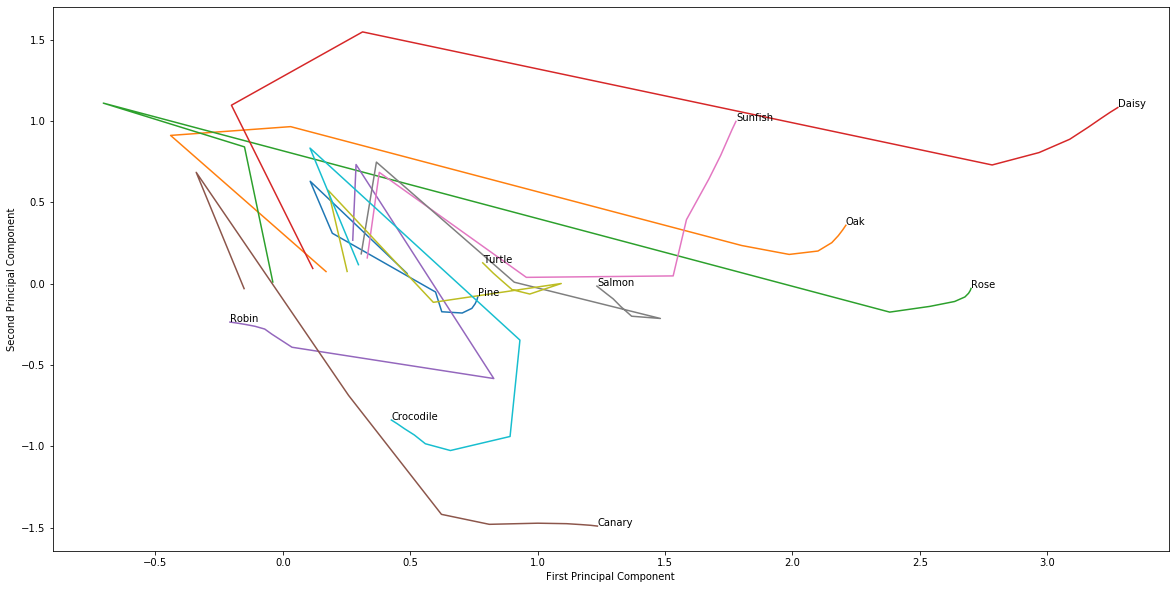

In [8]:
## The following observes principal components for the representation layer drawn out at different points in
## time of training. Essentially a multi-variate visualization to seeing differentiation through training.

inds_look = np.linspace(0,len(loaded_model['rep_layer']),10)
inds_look[-1] = inds_look[-1]-1
inds_look = list(map(int,inds_look))

projections = []

for ind in inds_look:
    mat = loaded_model['rep_layer'][ind]
    u,s,v = np.linalg.svd(mat.T.dot(mat))
    projection = mat.dot(v[:,:2])
    print('2 PCs explain {}% of variance'.format(round(100*(np.cumsum(s) / np.sum(s))[1],ndigits=2)))
    projections.append(projection)

plt.figure(figsize=(20,10))
for i in range(len(names_items)) :
    to_plot = np.array(projections)[:,i]
    plt.plot(to_plot[:,0],to_plot[:,1])
    plt.annotate(names_items[i],(to_plot[-1,0],to_plot[-1,1]))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [316]:
def apply_noise(net,scale) :
    
    model = copy.deepcopy(net) #otherwise actual model might change in place.
    model.eval()
    new_weights = model.state_dict()
    
    outputs_noisy = []
    dim2,dim3 = new_weights['i2rep.weight'].size()
    
    num_repititions = 10  # larger this gets, the more likely the effect is to average to zero.
    
    noisy_add = np.random.normal(scale=scale,size=(num_repititions,dim2,dim3)) 
    noisy_add = np.mean(noisy_add,axis=0)
    new_weights['i2rep.weight'] += noisy_add
    model.load_state_dict(new_weights)
    
    return model(input_pats)[0].detach().numpy()

In [317]:
final_out_mean = []

noise_level_test = [0,1,1.5,2,3]

for scale in noise_level_test :
    out = apply_noise(mynet,scale)
    final_out_mean.append(out)
    

final_out_mean = np.array(final_out_mean)

Showing NN Output for Oak Is :
Correct Answer is ['Big' 'Living']


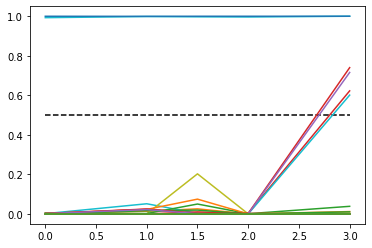

Noise Scale :  0
['Big' 'Living']
Noise Scale :  1
['Big' 'Living']
Noise Scale :  1.5
['Big' 'Living']
Noise Scale :  2
['Big' 'Living']
Noise Scale :  3
['Tree' 'Oak' 'Big' 'Living' 'Bark' 'Branch']


In [320]:
input_level_observe = 5

item_observe = names_items[input_pats[input_level_observe][:len(names_items)].numpy().astype('bool')][0]
attribute_observe = names_relations[input_pats[input_level_observe][len(names_items):].numpy().astype('bool')][0]

print('Showing NN Output for {} {} :'.format(item_observe,attribute_observe))
print('Correct Answer is {}'.format(names_attributes[output_pats[input_level_observe].numpy().astype('bool')]))

for i in range(final_out_mean[:,0].shape[1]) :
    plt.plot(noise_level_test,final_out_mean[:,input_level_observe,i])
plt.hlines(y=.5,xmin=noise_level_test[0],xmax=noise_level_test[-1],linestyle='--')
plt.show()

for i in range(final_out_mean.shape[0]) :
    print('Noise Scale : ',noise_level_test[i])
    print(names_attributes[np.where(final_out_mean[i,input_level_observe]>=.5,1,0).astype('bool')])